In [1]:
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np 
import shapely 
import osm_flex.download as dl
import osm_flex.extract as ex
from osm_flex.simplify import remove_contained_points,remove_exact_duplicates
from osm_flex.config import OSM_DATA_DIR,DICT_GEOFABRIK

from tqdm import tqdm

from lonboard import viz
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.sequential import Blues_9

from pathlib import Path
import pathlib

from shapely.validation import make_valid


In [2]:
#define paths
p = Path('..')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'

In [3]:
def country_download(iso3):
    dl.get_country_geofabrik(iso3)
    data_loc = OSM_DATA_DIR.joinpath(f'{DICT_GEOFABRIK[iso3][1]}-latest.osm.pbf')
    return data_loc

def overlay_hazard_assets(df_ds,assets):
    """
    Overlay hazard assets on a dataframe of spatial geometries.
    Arguments:
        *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
        *assets*: GeoDataFrame containing the infrastructure assets.
    Returns:
        *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the infrastructure assets.
    """
    #overlay #nts - review STRtree
    hazard_tree = shapely.STRtree(df_ds.geometry.values)
    if (shapely.get_type_id(assets.iloc[0].geometry) == 3) | (shapely.get_type_id(assets.iloc[0].geometry) == 6): # id types 3 and 6 stand for polygon and multipolygon
        return  hazard_tree.query(assets.geometry,predicate='intersects')    
    else:
        return  hazard_tree.query(assets.buffered,predicate='intersects')

def buffer_assets(assets,buffer_size=0.00083):
    """
    Buffer spatial assets in a GeoDataFrame.
    Arguments:
        *assets*: GeoDataFrame containing spatial geometries to be buffered.
        *buffer_size* (float, optional): The distance by which to buffer the geometries. Default is 0.00083.
    Returns:
        *GeoDataFrame*: A new GeoDataFrame with an additional 'buffered' column containing the buffered geometries.
    """
    assets['buffered'] = shapely.buffer(assets.geometry.values,distance=buffer_size)
    return assets

def get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).  
        *flood_numpified*: NumPy array representing flood hazard information.
        *asset_geom*: Shapely geometry representing the spatial coordinates of the asset.
        *curve*: Pandas DataFrame representing the curve for the asset type.
        *maxdam*: Maximum damage value. #maxdams list of maxdam
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """
    
    # find the exact hazard overlays:
    get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

    # estimate damage
    if len(get_hazard_points) == 0: # no overlay of asset with hazard
        return 0
    
    else:
        if asset_geom.geom_type == 'LineString':
            overlay_meters = shapely.length(shapely.intersection(get_hazard_points[:,1],asset_geom)) # get the length of exposed meters per hazard cell
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_meters*maxdam_asset) for maxdam_asset in maxdams] #return asset number, total damage for asset number (damage factor * meters * max. damage)
        elif asset_geom.geom_type in ['MultiPolygon','Polygon']:
            overlay_m2 = shapely.area(shapely.intersection(get_hazard_points[:,1],asset_geom))
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_m2*maxdam_asset) for maxdam_asset in maxdams]
        elif asset_geom.geom_type == 'Point':
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*maxdam_asset) for maxdam_asset in maxdams]

def read_hazard_data(data_path,hazard_type):

    if hazard_type == 'fluvial':
        hazard_data = data_path / 'Floods' / 'Germany' / 'fluvial_undefended' / 'raw_subsample' / 'validated_geometries'# need to make country an input
        #return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.shp']
        return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.geojson']
        #return list(hazard_data.iterdir())

    else:
        hazard_data = data_path / 'Floods' / 'Germany' / 'fluvial_undefended' / 'raw_subsample' / 'validated_geometries'# need to make country an input
        print('Warning! hazard not supported')
        return [file for file in hazard_data.iterdir() if file.is_file() and file.suffix == '.geojson']
     
def read_vul_maxdam(data_path,hazard_type,infra_type):

    vul_data = data_path / 'Vulnerability'

    if hazard_type in ['pluvial','fluvial']:  
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'F_Vuln_Depth',index_col=[0],header=[0,1,2,3,4])
    elif hazard_type == 'windstorm':
        curves = pd.read_excel(vul_data / 'Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx',sheet_name = 'W_Vuln_V10m',index_col=[0],header=[0,1,2,3,4])

    infra_curves =  curves.loc[:, curves.columns.get_level_values('Infrastructure description').str.lower().str.contains(infra_type)]
    
    maxdam = pd.read_excel(vul_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
    infra_descriptions=maxdam.index.get_level_values('Infrastructure description').str.lower().str.contains(infra_type)
    infra_maxdam = maxdam.loc[infra_descriptions,'Amount'].dropna()
    infra_maxdam = infra_maxdam[pd.to_numeric(infra_maxdam, errors='coerce').notnull()]
    
    return infra_curves,infra_maxdam


def read_flood_map(flood_map_path):

    # check if vector and return path, and vectorize if raster"
    print('Flood map path: '+str(flood_map_path))
    if '.shp' or '.geojson' in str(flood_map_path):
        # [Q1 - Elco] - should I try to re-vectorize/will it help overlay speed?
        return flood_map_path
    
    else: print('Vectorizing...')

    flood_map = xr.open_dataset(flood_map_path, engine="rasterio")

    flood_map_vector = flood_map['band_data'].to_dataframe().reset_index() #transform to dataframe
    
    # remove data that will not be used
    flood_map_vector = flood_map_vector.loc[(flood_map_vector.band_data > 0) & (flood_map_vector.band_data < 100)]
    
    # create geometry values and drop lat lon columns
    flood_map_vector['geometry'] = [shapely.points(x) for x in list(zip(flood_map_vector['x'],flood_map_vector['y']))]
    flood_map_vector = flood_map_vector.drop(['x','y','band','spatial_ref'],axis=1)
    
    # drop all non values to reduce size
    flood_map_vector = flood_map_vector.loc[~flood_map_vector['band_data'].isna()].reset_index(drop=True)
    
    # and turn them into squares again:
    flood_map_vector.geometry= shapely.buffer(flood_map_vector.geometry,distance=0.00083/2,cap_style='square').values # distance should be made an input still!

    return flood_map_vector


In [4]:
### source:  country_infrastructure_hazard() function Elco.

# use pre-downloaded data as source
#rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_Rhine_Alpine_DEU.geojson'
rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_KOBLENZ_BONN.geojson'
assets = gpd.read_file(rail_track_file)

assets.head(n=1)

osm_id railway  name gauge electrified voltage bridge maxspeed service  \
0  4349787    rail  None  1435          no    None   None       25    yard   

  tunnel                                         other_tags  \
0   None  "operator"=>"DB Netz AG","railway:lzb"=>"no","...   

  railway:traffic_mode usage                                         geometry  
0          "passenger"  None  LINESTRING (7.09858 50.73129, 7.09809 50.73144)

In [5]:
# convert assets to epsg3857, filter lines and rename column
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})
assets.head(n=2)

osm_id asset          name gauge electrified voltage bridge maxspeed  \
0  4349787  rail          None  1435          no    None   None       25   
1  4349788  rail  Voreifelbahn  1435          no    None    yes      100   

  service tunnel                                         other_tags  \
0    yard   None  "operator"=>"DB Netz AG","railway:lzb"=>"no","...   
1    None   None  "layer"=>"1","operator"=>"DB Netz AG","passeng...   

  railway:traffic_mode   usage  \
0          "passenger"    None   
1          "passenger"  "main"   

                                            geometry  
0  LINESTRING (790210.378 6573898.727, 790156.098...  
1  LINESTRING (781441.686 6569223.078, 781466.889...

In [6]:
# create dicts for quicker lookup
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()
print('Identified asset types:')
set(type_dict.values())
#[Q2 - Elco] can drop light rail/trams as they are not freight? Could underestimate damage

Identified asset types:


{'light_rail', 'rail'}

In [7]:
hazard_type='fluvial'
infra_type='rail'
country_code='DEU'

In [8]:
# read hazard data
hazard_data_list = read_hazard_data(data_path,hazard_type)
hazard_data_list

[WindowsPath('C:/Data/Floods/Germany/fluvial_undefended/raw_subsample/validated_geometries/DERP_RW_M_4326_subsample_valid_lmu.geojson')]

In [9]:
# read vulnerability and maxdam data:
curve_types = {'primary': ['F7.1', 'F7.2'],
                'secondary': ['F7.3', 'F7.4'],
                'rail': ['F8.1']}
infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)
print(f'Found matching infrastructure curves for {infra_type}:')
infra_curves.head(5)

Found matching infrastructure curves for rail:


ID number                                    F8.1                   F8.2  \
Infrastructure description               Railways               Railways   
Additional characteristics Double-tracked railway Double-tracked railway   
                              Unnamed: 30_level_3    Unnamed: 31_level_3   
Depth (m)                           Damage factor          Damage factor   
0.00                                     0.000000                  0.000   
0.05                                     0.016662                  0.014   
0.10                                     0.016662                  0.028   
0.15                                     0.016662                  0.042   
0.20                                     0.193036                  0.056   

ID number                                 F8.3                F8.4  \
Infrastructure description            Railways            Railways   
Additional characteristics                 N/A                 N/A   
                           Unnamed: 32_level_3 Unnamed: 33_level_3   
Depth (m)                        Damage factor       Damage factor   
0.00                                     0.000               0.000   
0.05                                     0.014               0.014   
0.10                                     0.028               0.020   
0.15                                     0.042               0.030   
0.20                                     0.056               0.040   

ID number                                 F8.5                F8.6  \
Infrastructure description            Railways            Railways   
Additional characteristics                 N/A                 N/A   
                           Unnamed: 34_level_3 Unnamed: 35_level_3   
Depth (m)                        Damage factor       Damage factor   
0.00                                     0.000            0.000000   
0.05                                     0.025            0.021444   
0.10                                     0.050            0.042887   
0.15                                     0.075            0.064331   
0.20                                     0.100            0.085775   

ID number                  F8.6a (lower boundary) F8.6b (upper boundary)  \
Infrastructure description               Railways               Railways   
Additional characteristics                    N/A                    N/A   
                              Unnamed: 36_level_3    Unnamed: 37_level_3   
Depth (m)                           Damage factor          Damage factor   
0.00                                     0.000000               0.000000   
0.05                                     0.014503               0.028385   
0.10                                     0.029005               0.056770   
0.15                                     0.043508               0.085154   
0.20                                     0.058010               0.113539   

ID number                                 F8.7                F8.8  
Infrastructure description            Railways            Railways  
Additional characteristics                 N/A     Railway station  
                           Unnamed: 38_level_3 Unnamed: 39_level_3  
Depth (m)                        Damage factor       Damage factor  
0.00                                  0.000000                0.00  
0.05                                  0.023222                0.02  
0.10                                  0.046444                0.04  
0.15                                  0.069666                0.06  
0.20                                  0.092887                0.08

In [11]:
collect_output = {}


In [12]:
single_footprint = hazard_data_list[0] #tqdm(hazard_data_list,total=len(hazard_data_list)):
hazard_name = single_footprint.parts[-1].split('.')[0]
print(f'Reading hazard map: {hazard_name}')

# load hazard map
if hazard_type in ['pluvial','fluvial']:
    hazard_map = read_flood_map(single_footprint)
    
# convert hazard data to epsg 3857
if '.shp' or '.geojson' in str(hazard_map):
    hazard_map=gpd.read_file(hazard_map).to_crs(3857)[['w_depth_l','w_depth_u','geometry']]
else:
    hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)
                  
       

Reading hazard map: DERP_RW_M_4326_subsample_valid_lmu
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\DERP_RW_M_4326_subsample_valid_lmu.geojson


In [43]:
hazard_map

w_depth_l  w_depth_u                                           geometry
0        0.0        0.5  MULTIPOLYGON (((825608.488 6516264.479, 825605...
1        1.0        2.0  MULTIPOLYGON (((846745.229 6510966.515, 846743...
2        2.0        4.0  MULTIPOLYGON (((829496.857 6483891.409, 829495...

In [13]:
q = hazard_map.iloc[0,-1]
q

In [44]:
type(q)

shapely.geometry.multipolygon.MultiPolygon

In [45]:
len([x for x in q.geoms])

10029

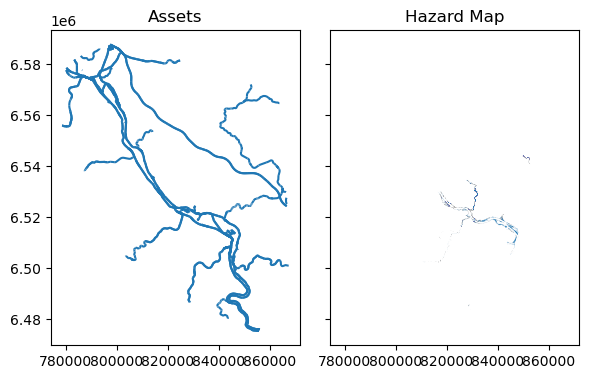

In [33]:
#plot assets and hazard map WARNING: can crash with many/complex geometries
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True)

# Plot assets on the first subplot
assets.plot(ax=axs[0])
axs[0].set_title('Assets')

# Plot hazard_map on the second subplot
hazard_map.plot(ax=axs[1])
axs[1].set_title('Hazard Map')

plt.tight_layout()
plt.show()

In [46]:
 # make any invalid geometries valid:
print('Verifying validity of hazard footprint geometries')
hazard_map.geometry = hazard_map.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1) 


Verifying validity of hazard footprint geometries


In [47]:
# from def overlay_hazard_assets(df_ds,assets):
"""
Overlay hazard assets on a dataframe of spatial geometries.
Arguments:
    *df_ds*: GeoDataFrame containing the spatial geometries of the hazard data. 
    *assets*: GeoDataFrame containing the infrastructure assets.
Returns:
    *geopandas.GeoSeries*: A GeoSeries containing the spatial geometries of df_ds that intersect with the infrastructure assets.
"""
df_ds=hazard_map

# buffer assets
buffered_assets=buffer_assets(assets)
buffered_assets.head(n=2)


osm_id asset          name gauge electrified voltage bridge maxspeed  \
0  4349787  rail          None  1435          no    None   None       25   
1  4349788  rail  Voreifelbahn  1435          no    None    yes      100   

  service tunnel                                         other_tags  \
0    yard   None  "operator"=>"DB Netz AG","railway:lzb"=>"no","...   
1    None   None  "layer"=>"1","operator"=>"DB Netz AG","passeng...   

  railway:traffic_mode   usage  \
0          "passenger"    None   
1          "passenger"  "main"   

                                            geometry  \
0  LINESTRING (790210.378 6573898.727, 790156.098...   
1  LINESTRING (781441.686 6569223.078, 781466.889...   

                                            buffered  
0  POLYGON ((790156.0979991176 6573925.229923702,...  
1  POLYGON ((781466.8892624202 6569173.650957938,...

In [48]:

hazard_tree = shapely.STRtree(df_ds.geometry.values)
hazard_tree.geometries


array([<MULTIPOLYGON (((8.26e+05 6.52e+06, 8.26e+05 6.52e+06, 8.26e+05 6.52e+06, 8....>,
       <MULTIPOLYGON (((8.47e+05 6.51e+06, 8.47e+05 6.51e+06, 8.47e+05 6.51e+06, 8....>,
       <MULTIPOLYGON (((8.29e+05 6.49e+06, 8.29e+05 6.49e+06, 8.29e+05 6.49e+06, 8....>],
      dtype=object)

In [40]:
# intersect assets with hazard tree
#[Q3 - Elco] IF we stick to large multi-polygons, is the hazard tree necessary? This is the slowest step atm.
if (shapely.get_type_id(assets.iloc[0].geometry) == 3) | (shapely.get_type_id(assets.iloc[0].geometry) == 6): # id types 3 and 6 stand for polygon and multipolygon
    print('polygon or multipolygon')
    output_1=hazard_tree.query(assets.geometry,predicate='intersects')    
else:
    output_2=hazard_tree.query(assets.buffered,predicate='intersects')

In [49]:
# Save and load hazard tree intersects to not run from scratch
f_name='intersect_'+hazard_name+'.csv'
save_output=data_path / 'interim' / f_name


In [ ]:

df = pd.DataFrame(output_2)
df.to_csv(save_output, header=False, index=False)
output_2


In [50]:
output_2_loaded = np.genfromtxt(save_output, delimiter=',', dtype=int)
output_2_loaded

array([[  41,  117,  118,  156,  186,  233,  283,  284,  285,  286,  400,
         492,  525,  530,  652,  656, 1001, 1008, 1014, 1023, 1142, 1142,
        1202, 1202, 1218, 1219, 1220, 1221, 1222, 1223, 1225, 1226, 1294,
        1296, 1297, 1300, 1457, 1461, 1464, 1615, 1620, 1623, 1627, 1686,
        1688, 1698, 1725, 1728, 1758, 1784, 1784, 1897, 2124, 2124, 2177,
        2349, 2531, 2563, 2581, 2581, 2582, 2582, 2583, 2583, 2642, 2668,
        2679, 2680, 2687, 2704, 2716, 2717, 2718, 2873, 2875, 2876, 2879,
        2881, 2883, 3083, 3085, 3089, 3092, 3093, 3132, 3133, 3134, 3135,
        3259, 3276, 3304, 3305],
       [   1,    2,    2,    0,    0,    1,    2,    2,    2,    2,    0,
           2,    0,    0,    0,    2,    2,    2,    2,    2,    2,    1,
           0,    1,    2,    2,    2,    2,    2,    2,    2,    2,    0,
           0,    0,    0,    0,    0,    0,    1,    1,    1,    1,    0,
           0,    2,    0,    0,    0,    2,    1,    1,    2,    1,    0,
     

In [27]:

intersected_assets=output_2_loaded
# overlay assets:
overlay_assets = pd.DataFrame(intersected_assets.T,columns=['asset','hazard_point'])
overlay_assets.tail(n=2)

asset  hazard_point
90   3304             2
91   3305             2

In [28]:
# convert dataframe to numpy array




In [63]:
#[Q4 - Elco] - should we use the upper or lower bound for flooding depth? And the bigger question, I can't understand why the result is the same with both
# convert dataframe to numpy array
#hazard_numpified = hazard_map.to_numpy() # modified to drop data
hazard_numpified = hazard_map.drop('w_depth_u', axis=1).to_numpy() 
hazard_numpified

#changed for upper and lower bounds
#hazard_numpified_u = hazard_map.drop('w_depth_l', axis=1).to_numpy() 
#hazard_numpified_l = hazard_map.drop('w_depth_u', axis=1).to_numpy()
#hazard_numpified_list=[hazard_numpified_l, hazard_numpified_u] 


array([[0.0,
        <MULTIPOLYGON (((8.26e+05 6.52e+06, 8.26e+05 6.52e+06, 8.26e+05 6.52e+06, 8....>],
       [1.0,
        <MULTIPOLYGON (((8.47e+05 6.51e+06, 8.47e+05 6.51e+06, 8.47e+05 6.51e+06, 8....>],
       [2.0,
        <MULTIPOLYGON (((8.29e+05 6.49e+06, 8.29e+05 6.49e+06, 8.29e+05 6.49e+06, 8....>]],
      dtype=object)

In [55]:
#[Q4 - Elco] - continued. Why does damage for each asset get considered for all maxdams? Shouldn't it be a single maxdam per asset?
#TODO does not return tuple but list of the same length as maxdams.
def get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).  
        *flood_numpified*: NumPy array representing flood hazard information.
        *asset_geom*: Shapely geometry representing the spatial coordinates of the asset.
        *curve*: Pandas DataFrame representing the curve for the asset type.
        *maxdam*: Maximum damage value. #maxdams list of maxdam
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """
    
    # find the exact hazard overlays:
    get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

    # estimate damage
    if len(get_hazard_points) == 0: # no overlay of asset with hazard
        return 0
    
    else:
        if asset_geom.geom_type == 'LineString':
            overlay_meters = shapely.length(shapely.intersection(get_hazard_points[:,1],asset_geom)) # get the length of exposed meters per hazard cell
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_meters*maxdam_asset) for maxdam_asset in maxdams] #return asset number, total damage for asset number (damage factor * meters * max. damage)
        
        elif asset_geom.geom_type in ['MultiPolygon','Polygon']:
            overlay_m2 = shapely.area(shapely.intersection(get_hazard_points[:,1],asset_geom))
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*overlay_m2*maxdam_asset) for maxdam_asset in maxdams]
        
        elif asset_geom.geom_type == 'Point':
            return [np.sum((np.interp(np.float16(get_hazard_points[:,0]),hazard_intensity,fragility_values))*maxdam_asset) for maxdam_asset in maxdams]


In [51]:
# Inspection code, to be removed
#asset[1]
#asset[1]['hazard_point']
#asset[1]['hazard_point'].values
#hazard_numpified_l[asset[1]['hazard_point'].values]
#hazard_numpified_l[asset[1]['hazard_point'].values][:,1]

In [53]:
# Inspection code, to be removed
#    get_hazard_points[shapely.intersects(get_hazard_points[:,1],asset_geom)]

#hazard_numpified_l[asset[1]['hazard_point'].values][:,1]


In [58]:
vul_data = data_path / 'Vulnerability'
maxdamxx = pd.read_excel(vul_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])

In [59]:
#[Q5 - Elco] Why is this run for each infrastructure curve and why for each maxdam value? Filtering only the selected maxdam value through maxdamxx variable
maxdam_types = {} #TODO use or remove?

for infra_curve in infra_curves:
    maxdams_filt=maxdamxx[maxdamxx['ID number']==infra_curve[0]]['Amount']
    print('Damage curve ID (infra_curve[0]): ', end='')
    print(infra_curve[0])
    if not infra_curve[0] in curve_types[infra_type]:continue
    # get curves
    curve = infra_curves[infra_curve[0]]
    hazard_intensity = curve.index.values
    fragility_values = (np.nan_to_num(curve.values,nan=(np.nanmax(curve.values)))).flatten()       
    collect_inb = {}
    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
        asset_type = type_dict[asset[0]]
        if not infra_curve[0] in curve_types[asset_type]: 
            collect_inb[asset_type] = 0

        if np.max(fragility_values) == 0:
            collect_inb[asset_type] = 0  
        else:
            asset_geom = geom_dict[asset[0]]
                            
            collect_inb[asset_type] = get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams_filt)
           # ollect_inb[asset_type] = tuple(get_damage_per_asset(asset,h_numpified,asset_geom,hazard_intensity,fragility_values,maxdams_filt)[0] for h_numpified in hazard_numpified_list)

    print(collect_inb)
    collect_output[hazard_name,infra_curve[0]] = pd.DataFrame.from_dict(collect_inb, orient='index').sum(axis=1)
    # collect_output[hazard_name,infra_curve[0],maxdam] = pd.DataFrame.from_dict(collect_inb).sum()
#break # remove break after testing

Damage curve ID (infra_curve[0]): F8.1


  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [04:33<00:00,  3.22s/it]

{'rail': [413406.23831245454]}
Damage curve ID (infra_curve[0]): F8.2
Damage curve ID (infra_curve[0]): F8.3
Damage curve ID (infra_curve[0]): F8.4
Damage curve ID (infra_curve[0]): F8.5
Damage curve ID (infra_curve[0]): F8.6
Damage curve ID (infra_curve[0]): F8.6a (lower boundary)
Damage curve ID (infra_curve[0]): F8.6b (upper boundary)
Damage curve ID (infra_curve[0]): F8.7
Damage curve ID (infra_curve[0]): F8.8


In [60]:
asset

(3305,
     asset  hazard_point
 91   3305             2)

In [61]:
collect_inb

{'rail': [413406.23831245454]}

END OF TESTING, old code begins here

In [81]:
def country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type):
    

    # get country osm data
    #data_loc = country_download(country_code)
    
    # get infrastructure data:
    #assets = ex.extract_cis(data_loc, infra_type)

    # use pre-downloaded data as source
    rail_track_file=data_path / 'Exposure' / 'raw_rail_track_study_area_KOBLENZ_BONN.geojson'
    assets = gpd.read_file(rail_track_file)
    
    # convert assets to epsg3857
    assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
    
    if infra_type == 'road':
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'highway' : 'asset'})
    elif infra_type == 'rail':
        #TODO Consider non LineString assets and distinguish between types of tracks. Also stations, switches, etc. (watch out - some max damages already consider them within the bulk sum unit cost)
        assets = assets.loc[assets.geometry.geom_type == 'LineString']
        assets = assets.rename(columns={'railway' : 'asset'})
    elif infra_type == 'education':
        assets = assets.rename(columns={'building' : 'asset'})
        assets = assets.reset_index(drop=True)
        assets = remove_contained_points(assets)

        #convert points to polygons
        assets.loc[assets.geom_type == 'Point','geometry'] = assets.loc[assets.geom_type == 'Point'].buffer(
                                                                        distance=np.sqrt(assets.loc[assets.geom_type == 'MultiPolygon'].area.median())/2, cap_style='square')

    elif infra_type == 'air':
        assets = assets.rename(columns={'aeroway' : 'asset'})
        
    
    # create dicts for quicker lookup
    geom_dict = assets['geometry'].to_dict()
    type_dict = assets['asset'].to_dict()
    print('Dictionary of asset types:')
    print(type_dict)
    
    # read hazard data
    hazard_data_list = read_hazard_data(data_path,hazard_type)
    
    # read vulnerability and maxdam data:
    infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)
    print(f'Found matching infrastructure curves for {infra_type}:')
    print(infra_curves.head())
    curve_types = {'primary': ['F7.1', 'F7.2'],
                  'secondary': ['F7.3', 'F7.4'],
                  'rail': ['F8.1']}



    # start analysis
    print('--ANALYSIS START--') 
    print(f'{country_code} runs for {infra_type} for {hazard_type} for {len(hazard_data_list)} maps for {len(infra_curves.T)*len(maxdams)} combinations')
    
    if hazard_type in ['windstorm','earthquake','landslide']:
        # load country geometry file and create geometry to clip
        ne_countries = gpd.read_file(data_path / "natural_earth" / "ne_10m_admin_0_countries.shp")
        bbox = ne_countries.loc[ne_countries['ISO_A3']==country_code].geometry.envelope.values[0].bounds


    collect_output = {}
    for single_footprint in hazard_data_list: #tqdm(hazard_data_list,total=len(hazard_data_list)):
        hazard_name = single_footprint.parts[-1].split('.')[0]
        print(f'Reading hazard map: {hazard_name}')
        
        # load hazard map
        if hazard_type in ['pluvial','fluvial']:
            hazard_map = read_flood_map(single_footprint)
        elif hazard_type in ['windstorm']:
             hazard_map = read_windstorm_map(single_footprint,bbox)
        elif hazard_type in ['earthquake']:
             hazard_map = read_earthquake_map(single_footprint)
        elif hazard_type in ['landslide']:
             hazard_map = read_landslide_map(single_footprint)
         
        # convert hazard data to epsg 3857
        if '.shp' in str(hazard_map):
            hazard_map=gpd.read_file(hazard_map).to_crs(3857)
        else:
            hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)
                  
        # make any invalid geometries valid:
        print('Verifying validity of hazard footprint geometries')
        hazard_map.geometry = hazard_map.apply(lambda row: make_valid(row.geometry) if not row.geometry.is_valid else row.geometry, axis=1) 


        # overlay assets:
        print('Overlaying assets')
        overlay_assets = pd.DataFrame(overlay_hazard_assets(hazard_map,buffer_assets(assets)).T,columns=['asset','hazard_point'])
        print('Asset overlay success!, numpifying array')
        # convert dataframe to numpy array
        hazard_numpified = hazard_map.to_numpy() 

        maxdam_types = {} #TODO use or remove?
        
        for infra_curve in infra_curves:
            print('Damage curve ID (infra_curve[0]): ', end='')
            print(infra_curve[0])
            if not infra_curve[0] in curve_types[infra_type]:continue
            # get curves
            curve = infra_curves[infra_curve[0]]
            hazard_intensity = curve.index.values
            fragility_values = (np.nan_to_num(curve.values,nan=(np.nanmax(curve.values)))).flatten()       
            collect_inb = {}
            for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
                    asset_type = type_dict[asset[0]]
            if not infra_curve[0] in curve_types[asset_type]: 
                collect_inb[asset_type] = 0

            if np.max(fragility_values) == 0:
                collect_inb[asset_type] = 0  
            else:
                asset_geom = geom_dict[asset[0]]
                                
                collect_inb[asset_type] = get_damage_per_asset(asset,hazard_numpified,asset_geom,hazard_intensity,fragility_values,maxdams)
            print(collect_inb)
            collect_output[hazard_name,infra_curve[0]] = pd.DataFrame.from_dict(collect_inb, orient='index').sum(axis=1)
            # collect_output[hazard_name,infra_curve[0],maxdam] = pd.DataFrame.from_dict(collect_inb).sum()
        #break # remove break after testing
    return collect_output

In [6]:
# List of critical infrastructure systems to process
cis = ['healthcare', 'education', 'gas', 'oil', 'telecom', 'water', 'wastewater', 'power', 'rail', 'road', 'air']

In [90]:
infra_curves,maxdams = read_vul_maxdam(data_path,hazard_type,infra_type)

In [91]:
maxdams

Infrastructure description
Railway                151.054965
Railway station      29601.412126
Railway station     291080.552573
Railways              6887.876551
Railways               491.205157
Railways               614.006446
Railways              5894.461879
Railways              7368.077349
Railways              24560.25783
Railways             24882.662967
Railways               6897.22639
Railways           3340904.232608
Railways           3340904.232608
Railways           3563631.181448
Railways              5343.615081
Railways               1335.90377
Name: Amount, dtype: object

In [9]:
infra_curves.columns.get_level_values(0)

Index(['F8.1', 'F8.2', 'F8.3', 'F8.4', 'F8.5', 'F8.6',
       'F8.6a (lower boundary)', 'F8.6b (upper boundary)', 'F8.7', 'F8.8'],
      dtype='object', name='ID number')

In [10]:
print(data_path,country_code,infra_type,hazard_type)

C:\Data DEU rail fluvial


In [11]:
test2 = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

Dictionary of asset types:
{0: 'rail', 1: 'rail', 2: 'light_rail', 3: 'light_rail', 4: 'rail', 5: 'light_rail', 6: 'light_rail', 7: 'light_rail', 8: 'light_rail', 9: 'light_rail', 10: 'light_rail', 11: 'rail', 12: 'rail', 13: 'rail', 14: 'rail', 15: 'rail', 16: 'rail', 17: 'light_rail', 18: 'light_rail', 19: 'rail', 20: 'rail', 21: 'light_rail', 22: 'light_rail', 23: 'rail', 24: 'light_rail', 25: 'light_rail', 26: 'light_rail', 27: 'light_rail', 28: 'light_rail', 29: 'light_rail', 30: 'light_rail', 31: 'light_rail', 32: 'light_rail', 33: 'light_rail', 34: 'light_rail', 35: 'light_rail', 36: 'light_rail', 37: 'rail', 38: 'rail', 39: 'rail', 40: 'rail', 41: 'rail', 42: 'rail', 43: 'rail', 44: 'rail', 45: 'rail', 46: 'rail', 47: 'rail', 48: 'rail', 49: 'rail', 50: 'rail', 51: 'rail', 52: 'rail', 53: 'rail', 54: 'rail', 55: 'rail', 56: 'rail', 57: 'rail', 58: 'rail', 59: 'rail', 60: 'rail', 61: 'rail', 62: 'rail', 63: 'rail', 64: 'rail', 65: 'rail', 66: 'rail', 67: 'light_rail', 68: 'light

100%|██████████| 85/85 [00:00<00:00, 9329.46it/s]


{'rail': [9053.938718708601, 1774250.6544519751, 17446798.102111086, 412845.8273133607, 29441.874828862572, 36802.34353607822, 353302.4979463509, 441628.1224329386, 1472093.7414431286, 1491418.0737840198, 413406.23831245454, 200247254.95903745, 200247254.95903745, 213597071.95630658, 320285.81997394946, 80071.45499348736]}
Damage curve ID (infra_curve[0]): F8.2
Damage curve ID (infra_curve[0]): F8.3
Damage curve ID (infra_curve[0]): F8.4
Damage curve ID (infra_curve[0]): F8.5
Damage curve ID (infra_curve[0]): F8.6
Damage curve ID (infra_curve[0]): F8.6a (lower boundary)
Damage curve ID (infra_curve[0]): F8.6b (upper boundary)
Damage curve ID (infra_curve[0]): F8.7
Damage curve ID (infra_curve[0]): F8.8


AttributeError: 'list' object has no attribute 'keys'

In [14]:
test2['DERP_RW_M_4326_subsample_valid']

In [35]:
test1 = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

Dictionary of asset types:
{0: 'rail', 1: 'rail', 2: 'light_rail', 3: 'light_rail', 4: 'rail', 5: 'light_rail', 6: 'light_rail', 7: 'light_rail', 8: 'light_rail', 9: 'light_rail', 10: 'light_rail', 11: 'rail', 12: 'rail', 13: 'rail', 14: 'rail', 15: 'rail', 16: 'rail', 17: 'light_rail', 18: 'light_rail', 19: 'rail', 20: 'rail', 21: 'light_rail', 22: 'light_rail', 23: 'rail', 24: 'light_rail', 25: 'light_rail', 26: 'light_rail', 27: 'light_rail', 28: 'light_rail', 29: 'light_rail', 30: 'light_rail', 31: 'light_rail', 32: 'light_rail', 33: 'light_rail', 34: 'light_rail', 35: 'light_rail', 36: 'light_rail', 37: 'rail', 38: 'rail', 39: 'rail', 40: 'rail', 41: 'rail', 42: 'rail', 43: 'rail', 44: 'rail', 45: 'rail', 46: 'rail', 47: 'rail', 48: 'rail', 49: 'rail', 50: 'rail', 51: 'rail', 52: 'rail', 53: 'rail', 54: 'rail', 55: 'rail', 56: 'rail', 57: 'rail', 58: 'rail', 59: 'rail', 60: 'rail', 61: 'rail', 62: 'rail', 63: 'rail', 64: 'rail', 65: 'rail', 66: 'rail', 67: 'light_rail', 68: 'light

100%|██████████| 85/85 [00:00<00:00, 42492.95it/s]


{'rail': [9053.938718708601, 1774250.6544519751, 17446798.102111086, 412845.8273133607, 29441.874828862572, 36802.34353607822, 353302.4979463509, 441628.1224329386, 1472093.7414431286, 1491418.0737840198, 413406.23831245454, 200247254.95903745, 200247254.95903745, 213597071.95630658, 320285.81997394946, 80071.45499348736]}
Damage curve ID (infra_curve[0]): F8.2
Damage curve ID (infra_curve[0]): F8.3
Damage curve ID (infra_curve[0]): F8.4
Damage curve ID (infra_curve[0]): F8.5
Damage curve ID (infra_curve[0]): F8.6
Damage curve ID (infra_curve[0]): F8.6a (lower boundary)
Damage curve ID (infra_curve[0]): F8.6b (upper boundary)
Damage curve ID (infra_curve[0]): F8.7
Damage curve ID (infra_curve[0]): F8.8


In [38]:
sum([9053.938718708601, 1774250.6544519751, 17446798.102111086, 412845.8273133607, 29441.874828862572, 36802.34353607822, 353302.4979463509, 441628.1224329386, 1472093.7414431286, 1491418.0737840198, 413406.23831245454, 200247254.95903745, 200247254.95903745, 213597071.95630658, 320285.81997394946, 80071.45499348736])

638372980.5642278

In [36]:
test1

{('DERP_RW_M_4326_subsample',
  'F8.1'): rail    6.383730e+08
 dtype: float64}

In [ ]:
test = country_infrastructure_hazard(data_path,country_code,infra_type,hazard_type)

ID number                                    F8.1                   F8.2  \
Infrastructure description               Railways               Railways   
Additional characteristics Double-tracked railway Double-tracked railway   
                              Unnamed: 30_level_3    Unnamed: 31_level_3   
Depth (m)                           Damage factor          Damage factor   
0.00                                     0.000000                  0.000   
0.05                                     0.016662                  0.014   
0.10                                     0.016662                  0.028   
0.15                                     0.016662                  0.042   
0.20                                     0.193036                  0.056   
...                                           ...                    ...   
6.30                                          NaN                    NaN   
6.35                                          NaN                    NaN   
6.40        

100%|██████████| 85/85 [00:23<00:00,  3.68it/s]


{'rail': 9053.938718708601}
maxdam:
29601.412126115203


100%|██████████| 85/85 [00:22<00:00,  3.71it/s]


{'rail': 1774250.6544519751}
maxdam:
291080.55257346615


100%|██████████| 85/85 [00:23<00:00,  3.58it/s]


{'rail': 17446798.102111086}
maxdam:
6887.876551255666


100%|██████████| 85/85 [00:24<00:00,  3.53it/s]


{'rail': 412845.8273133607}
maxdam:
491.20515660390225


100%|██████████| 85/85 [00:22<00:00,  3.72it/s]


{'rail': 29441.874828862572}
maxdam:
614.0064457548779


100%|██████████| 85/85 [00:23<00:00,  3.61it/s]


{'rail': 36802.34353607822}
maxdam:
5894.461879246827


100%|██████████| 85/85 [00:22<00:00,  3.71it/s]


{'rail': 353302.4979463509}
maxdam:
7368.077349058534


100%|██████████| 85/85 [00:22<00:00,  3.74it/s]


{'rail': 441628.1224329386}
maxdam:
24560.257830195114


100%|██████████| 85/85 [00:23<00:00,  3.69it/s]


{'rail': 1472093.7414431286}
maxdam:
24882.662967400163


100%|██████████| 85/85 [00:22<00:00,  3.72it/s]


{'rail': 1491418.0737840198}
maxdam:
6897.226389680445


100%|██████████| 85/85 [00:22<00:00,  3.74it/s]


{'rail': 413406.23831245454}
maxdam:
3340904.2326077837


100%|██████████| 85/85 [00:22<00:00,  3.73it/s]


{'rail': 200247254.95903745}
maxdam:
3340904.2326077837


100%|██████████| 85/85 [00:22<00:00,  3.74it/s]


{'rail': 200247254.95903745}
maxdam:
3563631.181448302


100%|██████████| 85/85 [00:22<00:00,  3.75it/s]


{'rail': 213597071.95630658}
maxdam:
5343.615081335874


100%|██████████| 85/85 [00:22<00:00,  3.72it/s]


{'rail': 320285.81997394946}
maxdam:
1335.9037703339684


100%|██████████| 85/85 [00:22<00:00,  3.75it/s]

{'rail': 80071.45499348736}
infra_curve[0]; F8.2
infra_curve[0]; F8.3
infra_curve[0]; F8.4
infra_curve[0]; F8.5
infra_curve[0]; F8.6
infra_curve[0]; F8.6a (lower boundary)
infra_curve[0]; F8.6b (upper boundary)
infra_curve[0]; F8.7
infra_curve[0]; F8.8


In [ ]:
test

{('DERP_RW_M_4326_subsample',
  'F8.1',
  151.05496548900337): rail    9053.938719
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  29601.412126115203): rail    1.774251e+06
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  291080.55257346615): rail    1.744680e+07
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  6887.876551255666): rail    412845.827313
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  491.20515660390225): rail    29441.874829
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  614.0064457548779): rail    36802.343536
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  5894.461879246827): rail    353302.497946
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  7368.077349058534): rail    441628.122433
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  24560.257830195114): rail    1.472094e+06
 dtype: float64,
 ('DERP_RW_M_4326_subsample',
  'F8.1',
  24882.662967400163): rail    1.491418e+06
 dtype: f